In [1]:
import pandas as pd
import seaborn as sns
from pydataset import data

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
def train_validate_test_split(df, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed)
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed)
    return train, validate, test

In [3]:
df = data("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4


In [4]:
# Data Preparation
dummy_df = pd.get_dummies(df[['day']])
df = pd.concat([df, dummy_df], axis=1)

df["is_female"] = df.sex == "Female"
df.smoker = df.smoker == "Yes"
df["is_dinner"] = df.time == "Dinner"

df = df.drop(columns=["time", "sex"])
df.head()

,total_bill,tip,smoker,day,size,day_Fri,day_Sat,day_Sun,day_Thur,is_female,is_dinner
1,16.99,1.01,False,Sun,2,0,0,1,0,True,True
2,10.34,1.66,False,Sun,3,0,0,1,0,False,True
3,21.01,3.50,False,Sun,3,0,0,1,0,False,True
4,23.68,3.31,False,Sun,2,0,0,1,0,False,True
5,24.59,3.61,False,Sun,4,0,0,1,0,True,True


In [5]:
train, validate, test = train_validate_test_split(df)

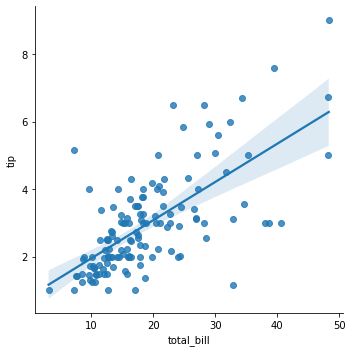

In [6]:
sns.lmplot(x="total_bill", y="tip", data=train)

In [7]:
# Separate out my X and y variables
X_train = train.drop(columns=["tip", "day"])
y_train = train[["tip"]]

X_validate = validate.drop(columns=["tip", "day"])
y_validate = validate[["tip"]]

X_test = test.drop(columns=["tip", "day"])
y_test = test[["tip"]]

In [8]:
y_train["mean"] = y_train.tip.mean()

/var/folders/d_/7tbp5nsn0675p_4kcchp75k80000gp/T/ipykernel_99058/590453748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train["mean"] = y_train.tip.mean()


In [9]:
baseline_rmse = mean_squared_error(y_train.tip, y_train["mean"])**(1/2)
f"Baseline RMSE: ${round(baseline_rmse, 2)}"

'Baseline RMSE: $1.45'

In [10]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tip)

# predict train
y_train['tweedie_pred'] = glm.predict(X_train)


/var/folders/d_/7tbp5nsn0675p_4kcchp75k80000gp/T/ipykernel_99058/1169036073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['tweedie_pred'] = glm.predict(X_train)


In [14]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tip, y_train["tweedie_pred"])**(1/2)
f"In-sample RMSE: ${round(rmse_train, 2)}"

'In-sample RMSE: $1.04'

In [19]:
# Evaluate on Validate
y_validate["tweedie_pred"] = glm.predict(X_validate)

/var/folders/d_/7tbp5nsn0675p_4kcchp75k80000gp/T/ipykernel_99058/238603552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_validate["tweedie_pred"] = glm.predict(X_validate)


In [15]:
rmse_validate = mean_squared_error(y_validate.tip, y_validate["tweedie_pred"])**(1/2)
f"Out of sample RMSE: ${round(rmse_validate, 2)}"

'Out of sample RMSE: $1.16'